# PP Chains

There are multiple proton-proton chains.

* PP-I involves: $p$, $d$, ${}^3\mathrm{He}$, ${}^4\mathrm{He}$
* PP-II adds: ${}^7\mathrm{Li}$, ${}^7\mathrm{Be}$
* PP-III adds: ${}^8\mathrm{Be}$, ${}^8\mathrm{B}$
  
Here we can explore them all.

## Creating a network

We'll use pynucastro to create a network with all of these nuclei.

In [1]:
import pynucastro as pyna

In [2]:
net = pyna.network_helper(["p", "d", "he3", "he4",
                           "li7", "be7", "be8", "b8"])

modifying He3 ⟶ p + H2 from H2 + p ⟶ He3 + 𝛾
modifying He4 ⟶ H2 + H2 from H2 + H2 ⟶ He4 + 𝛾
modifying Be7 ⟶ He4 + He3 from He3 + He4 ⟶ Be7 + 𝛾
modifying B8 ⟶ p + Be7 from Be7 + p ⟶ B8 + 𝛾
modifying p + He4 ⟶ H2 + He3 from He3 + H2 ⟶ p + He4
modifying He4 + He4 ⟶ p + Li7 from Li7 + p ⟶ He4 + He4
modifying p + p + He4 ⟶ He3 + He3 from He3 + He3 ⟶ p + p + He4
modifying p + He4 + He4 ⟶ H2 + Be7 from Be7 + H2 ⟶ p + He4 + He4
modifying p + p + He4 + He4 ⟶ He3 + Be7 from Be7 + He3 ⟶ p + p + He4 + He4


```{note}
ReacLib does not provide the rate for ${}^8\mathrm{Be} \rightarrow \alpha + \alpha$ because it is so short lived.  It essentially will break apart into two $\alpha$ immediately.  It instead has a rate that combines:

$${}^8\mathrm{B} \rightarrow {}^8\mathrm{Be} + e^+ + \nu_e$$

$${}^8\mathrm{Be} \rightarrow \alpha + \alpha$$
```

## Approximating composition in Sun's core

We need a reasonably accurate estimate for the composition in the core of the Sun.  We'll find this by integrating an initial H/He mix for 4.5 billion years--this should find an equilibrium

In [3]:
tmax = 4.5e9 * 365.25 * 24 * 3600
tmax

1.420092e+17

In [4]:
net.write_network("pp.py")
import pp

/raid/zingale/development/pynucastro/pynucastro/rates/derived_rate.py:126: UserWarning: He3 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))
/raid/zingale/development/pynucastro/pynucastro/rates/derived_rate.py:126: UserWarning: d partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))
/raid/zingale/development/pynucastro/pynucastro/rates/derived_rate.py:126: UserWarning: Be7 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))
/raid/zingale/development/pynucastro/pynucastro/rates/derived_rate.py:126: UserWarning: B8 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserW

We'll integrate this using solve_ivp

In [5]:
import numpy as np
from scipy.integrate import solve_ivp

In [6]:
X0 = np.zeros(pp.nnuc)
X0[pp.jp] = 0.72
X0[pp.jhe4] = 0.28

Y0 = X0 / pp.A

In [7]:
rho = 150
T = 1.5e7

In [8]:
sol = solve_ivp(pp.rhs, [0, tmax], Y0, method="BDF", jac=pp.jacobian,
                dense_output=True, args=(rho, T), rtol=1.e-7, atol=1.e-12)

Now let's get the composition at the final time

In [18]:
X_final = sol.y[:, -1] * pp.A
X_final

array([2.81318714e-01, 2.04411172e-18, 8.77279202e-06, 7.18672513e-01,
       2.03687202e-15, 9.99888210e-12, 4.53092291e-54, 1.95666221e-21])

and create a pynucastro Composition from this

In [10]:
comp = pyna.Composition(net.unique_nuclei)
comp.set_array(X_final)
print(comp)

  X(p) : 0.28131871449282164
  X(d) : 2.0441117249462732e-18
  X(He3) : 8.772792020130378e-06
  X(He4) : 0.7186725127051565
  X(Li7) : 2.0368720231888285e-15
  X(Be7) : 9.998882102842114e-12
  X(Be8) : 4.530922913017406e-54
  X(B8) : 1.956662207786176e-21



## Importance of PP-I vs. PP-II

We can evaluate the rates with this composition

In [11]:
r_sun = net.evaluate_rates(rho, T, comp)

/raid/zingale/development/pynucastro/pynucastro/rates/derived_rate.py:126: UserWarning: He3 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))
/raid/zingale/development/pynucastro/pynucastro/rates/derived_rate.py:126: UserWarning: d partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))
/raid/zingale/development/pynucastro/pynucastro/rates/derived_rate.py:126: UserWarning: Be7 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))
/raid/zingale/development/pynucastro/pynucastro/rates/derived_rate.py:126: UserWarning: B8 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserW

Let's look at just the rates that consume ${}^3\mathrm{He}$

In [12]:
for r in r_sun:
    if pyna.Nucleus("he3") in r.reactants:
        print(f"{str(r):30}: {r_sun[r]:12.6g}")

He3 + p ⟶ He4 + e⁺ + 𝜈        :  2.73268e-26
He3 + He4 ⟶ Be7 + 𝛾           :  1.97861e-19
He3 + H2 ⟶ p + He4            :  9.85879e-23
He3 + He3 ⟶ p + p + He4       :  1.42325e-19
Be7 + He3 ⟶ p + p + He4 + He4 :  2.64203e-39
He3 ⟶ p + H2                  :            0


Notice that the rate of ${}^3\mathrm{He}({}^3\mathrm{He},pp){}^4\mathrm{He}$ is only slightly slower than ${}^4\mathrm{He}({}^3\mathrm{He},\gamma){}^7\mathrm{Be}$ at this point.

In [13]:
r33 = net.get_rate_by_name("he3(he3,pp)he4")
r34 = net.get_rate_by_name("he4(he3,g)be7")

ratio = r_sun[r33] / r_sun[r34]
ratio

np.float64(0.7193207261903833)

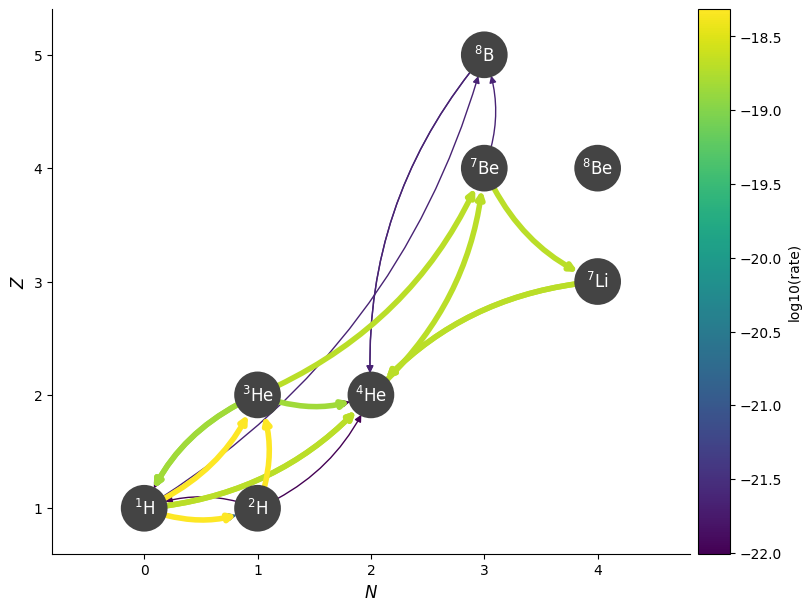

In [14]:
fig = net.plot(rho, T, comp,
               curved_edges=True,
               always_show_alpha=True,
               always_show_p=True,
               ydot_cutoff_value=1.e-25)

Now let's consider a bit hotter.  We'll keep the same composition

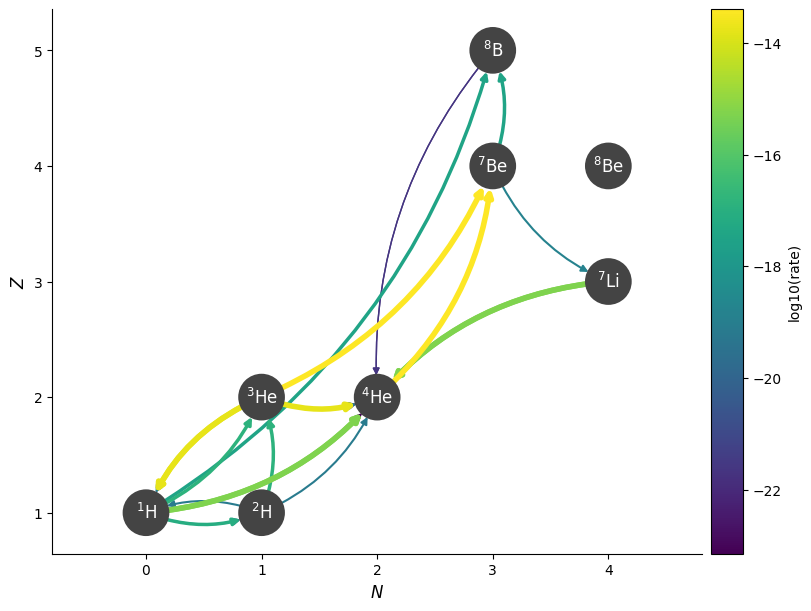

In [19]:
T = 3.5e7 

fig = net.plot(rho, T, comp,
               curved_edges=True,
               always_show_alpha=True,
               always_show_p=True,
               ydot_cutoff_value=1.e-25)

In [16]:
r_hot = net.evaluate_rates(rho, T, comp)
ratio_hot = r_hot[r33] / r_hot[r34]
ratio_hot

np.float64(0.41694689409397745)

Now we see that ${}^4\mathrm{He}({}^3\mathrm{He},\gamma){}^7\mathrm{Be}$ is much faster.

Overall, as the temperature increases, we see that the ${}^4\mathrm{He}({}^3\mathrm{He},\gamma){}^7\mathrm{Be}$ rate is more active.

```{note}
These rates are _strongly_ dependent on the amount of ${}^3\mathrm{He}$ present, so we should really compute the equilibrium abundance before making the comparisons.
```